In [1]:
# Shay Redding
# 11/27

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from scipy import stats

# visual style
sns.set(style='whitegrid')
# declutter warnings
warnings.filterwarnings('ignore')

In [3]:
# Load Data and Quick Clean for binary classification

# load data
data = pd.read_csv('../data/raw/TWOSIDES.csv', nrows=5000, low_memory=False)

# remove columns we don't care about and rename columns for ease
data = data.rename(columns={
    'drug_1_concept_name': 'drug_1',
    'drug_2_concept_name': 'drug_2',
    'condition_concept_name': 'condition'})
necessary_columns = ['drug_1', 'drug_2', 'condition', 'PRR', 'PRR_error', 'mean_reporting_frequency']
data = data[necessary_columns]

# remove 'drug_1/2_concept_name' from rows
data = data[
    ~data['drug_1'].str.contains('concept_name', case=False, na=False) &
    ~data['drug_2'].str.contains('concept_name', case=False, na=False)
]

data = data.drop_duplicates(subset=['drug_1', 'drug_2', 'condition'])

In [4]:
# Data Overview

print(f'Columns:\n{data.columns.tolist()}\n')
print(f'Shape: {data.shape[0]} rows x {data.shape[1]} columns\n')
print(f'Data Types:\n{data.dtypes}\n')

# missing values
missing = data.isnull().sum()

if missing.sum() == 0:
    print('no missing values.')

Columns:
['drug_1', 'drug_2', 'condition', 'PRR', 'PRR_error', 'mean_reporting_frequency']

Shape: 3999 rows x 6 columns

Data Types:
drug_1                      object
drug_2                      object
condition                   object
PRR                         object
PRR_error                   object
mean_reporting_frequency    object
dtype: object

no missing values.


In [5]:
# Basic Stats

# unique drug count
unique_drug_1 = data['drug_1'].nunique()
unique_drug_2 = data['drug_2'].nunique()
unique_drugs = set(data['drug_1']) | set(data['drug_2'])
unique_count = len(unique_drugs)

print(f'Unique drugs in col 1: {unique_drug_1}')
print(f'Unique drugs in col 2: {unique_drug_2}')
print(f'Total  drugs: {unique_count}')

# interaction counts
drug_count = pd.concat([
    data['drug_1'].value_counts(),
    data['drug_2'].value_counts()]).groupby(level=0).sum()

# per drug interactions
print(f'Mean interactions: {drug_count.mean():.2f}')
print(f'Median interactions: {drug_count.median():.2f}')
print(f'Standard deviation: {drug_count.std():.2f}')
print(f'Minimum interactions: {drug_count.min():.2f}')
print(f'Maximum interactions: {drug_count.max():.2f}')

# quartiles
Q1, Q2, Q3 = drug_count.quantile([0.25, 0.5, 0.75])

print('\nInteraction Quartiles:')
print(f'Q1: {Q1}')
print(f'Q2: {Q2}')
print(f'Q3: {Q3}')

# interquartile range
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = drug_count[(drug_count < lower_bound) | (drug_count > upper_bound)]

print(f'\nIQR outliers: {len(outliers)}')
print('\nTop 10 outliers:')
for drug, count in outliers.nlargest(10).items():
    print(f'{drug}: {count}')

Unique drugs in col 1: 16
Unique drugs in col 2: 16
Total  drugs: 32
Mean interactions: 249.94
Median interactions: 58.50
Standard deviation: 357.66
Minimum interactions: 8.00
Maximum interactions: 1382.00

Interaction Quartiles:
Q1: 27.75
Q2: 58.5
Q3: 443.5

IQR outliers: 2

Top 10 outliers:
Fluconazole: 1382
Promethazine: 1382


In [6]:
# Basic Frequency Analysis

drug_1_count = data['drug_1'].value_counts()
drug_2_count = data['drug_2'].value_counts()
total_drug_count = pd.concat([drug_1_count, drug_2_count]).groupby(level=0).sum()

# list top 25 
print(f'\nMost Interactive Drugs:')
top_25 = total_drug_count.nlargest(25)
print(f"{'Rank':<6} {'Drug Name':<40} {'Interactions':>12}")
for rank, (drug, count) in enumerate(top_25.items(), 1):
    print(f'{rank:<6} {drug:<40} {count:>12,}')

# list bottom 25 
bot_25 = total_drug_count.nsmallest(25)
print(f'\nLeast Interactive Drugs:')
print(f"{'Rank':<6} {'Drug Name':<40} {'Interactions':>12}")
for rank, (drug, count) in enumerate(bot_25.items(), 1):
    print(f'{rank:<6} {drug:<40} {count:>12,}')


Most Interactive Drugs:
Rank   Drug Name                                Interactions
1      Fluconazole                                     1,382
2      Promethazine                                    1,382
3      Triamcinolone                                     562
4      fexofenadine                                      562
5      Prednisone                                        506
6      Tamoxifen                                         506
7      Buprenorphine                                     481
8      Levetiracetam                                     481
9      Temazepam                                         431
10     sildenafil                                        431
11     Hydroxychloroquine                                250
12     POLYETHYLENE GLYCOL 3350                          250
13     Mepivacaine                                        91
14     ropivacaine                                        91
15     Bumetanide                                         59

In [7]:
# Specific Interaction Patterns
pair_counts = data.groupby(['drug_1', 'drug_2']).size().sort_values(ascending=False)

print(f'Top 25 drug pairs by interaction count')
for i, ((drug_1, drug_2), count) in enumerate(pair_counts.head(25).items(), 1):
    print(f'{i:2d}. {drug_1} - {drug_2}: {count} interactions')


Top 25 drug pairs by interaction count
 1. Promethazine - Fluconazole: 1382 interactions
 2. fexofenadine - Triamcinolone: 562 interactions
 3. Tamoxifen - Prednisone: 506 interactions
 4. Levetiracetam - Buprenorphine: 481 interactions
 5. Temazepam - sildenafil: 431 interactions
 6. POLYETHYLENE GLYCOL 3350 - Hydroxychloroquine: 250 interactions
 7. ropivacaine - Mepivacaine: 91 interactions
 8. Bumetanide - Oxytocin: 59 interactions
 9. Pyridostigmine - Ciprofloxacin: 58 interactions
10. Oxazepam - Sodium Chloride: 51 interactions
11. Acetaminophen - glycopyrronium: 33 interactions
12. fluticasone - carfilzomib: 30 interactions
13. metaproterenol - Triamterene: 21 interactions
14. Ibuprofen - zileuton: 18 interactions
15. Urea - Amoxicillin: 18 interactions
16. lornoxicam - pioglitazone: 8 interactions


In [8]:
# Basic Statistical Tests

# normality
stat, p_value = stats.shapiro(total_drug_count.sample(min(5000, len(total_drug_count))))
print(f"Statistic: {stat:.4f}")
print(f"P-value: {p_value:.4e}")

skewness = total_drug_count.skew()
kurtosis = total_drug_count.kurt()

print(f'Skewness: {skewness:.4f}')
print(f'Kurtosis: {kurtosis:.4f}')

print(f'High skewness (>1) here means that a few drugs have many interactions.')
print(f'High Kurtosis value (>3) here means there are many outliers.')


Statistic: 0.6760
P-value: 3.8754e-07
Skewness: 2.1334
Kurtosis: 4.7330
High skewness (>1) here means that a few drugs have many interactions.
High Kurtosis value (>3) here means there are many outliers.


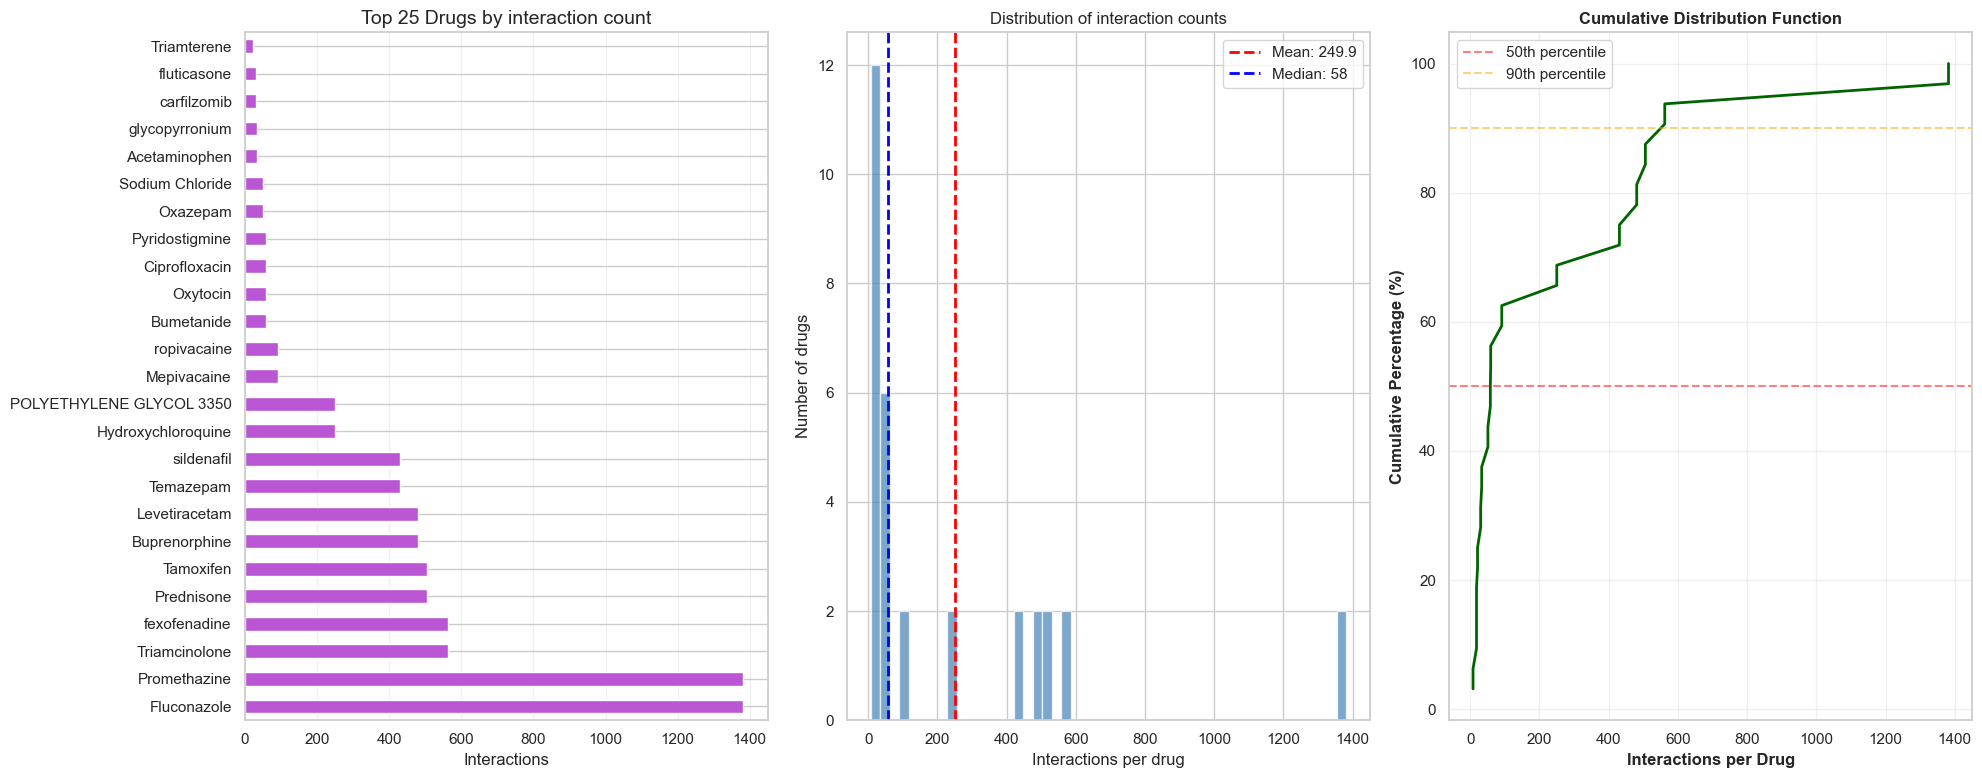

In [9]:
# Visualizations

figure = plt.figure(figsize=(20, 15))

# top drug bar chart
chart1 = plt.subplot(2, 3, 1)
top_25.plot(kind='barh', ax=chart1, color='mediumorchid')
chart1.set_xlabel('Interactions')
chart1.set_title('Top 25 Drugs by interaction count', fontsize=14)
chart1.grid(axis='x', alpha=0.3)

# distribution histo
chart2 = plt.subplot(2, 3, 2)
chart2.hist(total_drug_count, bins=50, color='steelblue', alpha=0.7)
chart2.axvline(total_drug_count.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {total_drug_count.mean():.1f}')
chart2.axvline(total_drug_count.median(), color='blue', linestyle='--', linewidth=2, label=f'Median: {total_drug_count.median():.0f}')
chart2.set_xlabel('Interactions per drug')
chart2.set_ylabel('Number of drugs')
chart2.set_title('Distribution of interaction counts')
chart2.legend()

# distribution
chart3 = plt.subplot(2, 3, 3)
sorted_counts = np.sort(total_drug_count)
cumulative = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts) * 100
chart3.plot(sorted_counts, cumulative, linewidth=2, color='darkgreen')
chart3.axhline(50, color='red', linestyle='--', alpha=0.5, label='50th percentile')
chart3.axhline(90, color='orange', linestyle='--', alpha=0.5, label='90th percentile')
chart3.set_xlabel('Interactions per Drug', fontweight='bold')
chart3.set_ylabel('Cumulative Percentage (%)', fontweight='bold')
chart3.set_title('Cumulative Distribution Function', fontweight='bold', fontsize=12)
chart3.legend()
chart3.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/initial-eda-charts.png', dpi=300, bbox_inches='tight')
plt.show()

# heatmap


In [10]:
# Initial Conclusions
# figure out duplicates with this data

print(f'''
Summary:
    total drug pairs: {len(data)}
    unique drugs: {unique_count}
    average interaction per drug: {total_drug_count.mean():.2f}
    missing values: {missing.sum()} 

Distribution/Statistical Properties:
    skewness: {skewness:.2f}; indicates right-skewed distribution
    top 5% of drugs have: {drug_count.quantile(0.95):.0f} interactions
    outliers: {len(outliers)}
    p-value: {p_value:.4e}; indicates non-normal distribution
    
Interaction Patterns:
    most interactive drug: {drug_count.idxmax()} ({drug_count.max()} interactions)

    ''')



summary_stats = pd.DataFrame({
    'Metric': [
        'Total Interactions', 'Unique Drugs', 'Mean Interactions/Drug',
        'Median Interactions/Drug', 'Std Dev', 'Skewness', 'Kurtosis',
        'Outliers'
    ],
    'Value': [
        f'{len(data):,}', f'{unique_count:,}', f'{drug_count.mean():.2f}',
        f'{drug_count.median():.0f}', f'{drug_count.std():.2f}',
        f'{skewness:.4f}', f'{kurtosis:.4f}', f'{len(outliers)}'
    ]
})

summary_stats.to_csv('../data/processed/eda_summary.csv', index=False)


Summary:
    total drug pairs: 3999
    unique drugs: 32
    average interaction per drug: 249.94
    missing values: 0 

Distribution/Statistical Properties:
    skewness: 2.13; indicates right-skewed distribution
    top 5% of drugs have: 931 interactions
    outliers: 2
    p-value: 3.8754e-07; indicates non-normal distribution

Interaction Patterns:
    most interactive drug: Fluconazole (1382 interactions)

    


In [11]:
# clean and prep for binary classification

# convert prr to float
data['PRR'] = pd.to_numeric(data['PRR'])

# filter for only significant interactions
print(f'before filtering for prr >= 2: {len(data)}')
data = data[data['PRR'] >= 2.0]
print(f'after filtering for prr >= 2: {len(data)}')

# prr distribution stats
print(f'mean prr: {data['PRR'].mean():.2f}')
print(f'median prr: {data['PRR'].median():.2f}')
print(f'max prr: {data['PRR'].max():.2f}')

# group by drug pair and amount of interactions
data_binary = data.groupby(['drug_1', 'drug_2']).size().reset_index(name='num_side_effects')

print(f"Average side effects per pair: {data_binary['num_side_effects'].mean():.1f}")
print(f"Median side effects per pair: {data_binary['num_side_effects'].median():.0f}")
print(f"Max side effects for one pair: {data_binary['num_side_effects'].max()}")

data_binary = data_binary[['drug_1', 'drug_2']].copy()
data_binary['interaction'] = 1

print(f'{len(data_binary)} unique pairs')

unique_drugs_final = pd.concat([data_binary['drug_1'], data_binary['drug_2']]).nunique()

print(f"unique drug pairs: {len(data_binary):,}")
print(f"unique drugs: {unique_drugs_final:,}")
print(f"all pairs labeled as interactions (1)")

data_binary.to_csv('../data/processed/data_binary.csv')


before filtering for prr >= 2: 3999
after filtering for prr >= 2: 3394
mean prr: 9.14
median prr: 6.67
max prr: 180.00
Average side effects per pair: 212.1
Median side effects per pair: 58
Max side effects for one pair: 1191
16 unique pairs
unique drug pairs: 16
unique drugs: 32
all pairs labeled as interactions (1)
